# Forescast - Séries Temporais com Keras

## Análise de dados de consumo de energia

**Cenário do Projeto**

Utilizaremos dados históricos de consumo de energia de 2005 até julho de 2024 e vamos  prever o consumo de agosto de 2024 até dezembro de 2034.

**Resumo dos dados**

* Período total: 2005-01-01 até 2034-12-01 (360 registros)
* Dados históricos: 235 registros com consumo (2005-01 até 2024-07)
* Período de previsão: 125 registros sem consumo (2024-08 até 2034-12)
* Variáveis explicativas: Disponíveis para todo o período

**Variáveis Disponíveis**

* consumo_energia_mwh: consumo de energia (TARGET - apenas até 2024-07)
* tarifa_energia: tarifa da energia (conhecido para o futuro)
* dias_uteis: número de dias úteis (conhecido para o futuro)
* pop_domicilio: população por domicílio (projetado para o futuro)
* Temperatura_media: temperatura média (projetado para o futuro)
* Amplitude_termica: amplitude térmica (projetado para o futuro)

### Importar bibliotecas

In [1]:
!pip install autokeras > /dev/null
!pip install keras-tuner > /dev/null

In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
import autokeras as ak
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import joblib
warnings.filterwarnings('ignore')
import random
import os

print(f"TensorFlow versão: {tf.__version__}")
# Verificar versão do AutoKeras
print(f" Versão AutoKeras: {ak.__version__}")

# Definir seed global
SEED = 2024
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

TensorFlow versão: 2.18.0
 Versão AutoKeras: 2.0.0


### Conectar no google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Importar dados

In [4]:
# Carregar dados do Excel
df = pd.read_excel('/content/drive/MyDrive/Tensor_flow_TS/dados/dados.xlsx', sheet_name='Sheet 1')

# Imformações
print(df.info())

# visualizar
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   data                 360 non-null    datetime64[ns]
 1   consumo_energia_mwh  235 non-null    float64       
 2   tarifa_energia       360 non-null    int64         
 3   dias_uteis           360 non-null    int64         
 4   pop_domicilio        360 non-null    float64       
 5   Temperatura_media    360 non-null    float64       
 6   Amplitude_termica    360 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 19.8 KB
None


,data,consumo_energia_mwh,tarifa_energia,dias_uteis,pop_domicilio,Temperatura_media,Amplitude_termica
0,2005-01-01,377945.0,272,21,4.341,26.23,9.160
1,2005-02-01,337537.0,271,18,4.340,25.27,6.100
2,2005-03-01,379428.0,271,23,4.340,25.14,6.020
3,2005-04-01,371193.0,270,20,4.340,25.12,4.910
4,2005-05-01,384412.0,275,21,4.339,25.26,5.590
...,...,...,...,...,...,...,...
355,2034-08-01,NaN,1170,23,2.735,26.48,7.772
356,2034-09-01,NaN,1195,20,2.733,26.83,8.410
357,2034-10-01,NaN,1196,21,2.731,27.03,8.594
358,2034-11-01,NaN,1196,20,2.729,26.60,8.690


### Preparar coluna data e verificar missings


Período dos dados: 2005-01-01 00:00:00 até 2034-12-01 00:00:00
Total de registros: 360
consumo_energia_mwh    125
tarifa_energia           0
dias_uteis               0
pop_domicilio            0
Temperatura_media        0
Amplitude_termica        0
dtype: int64


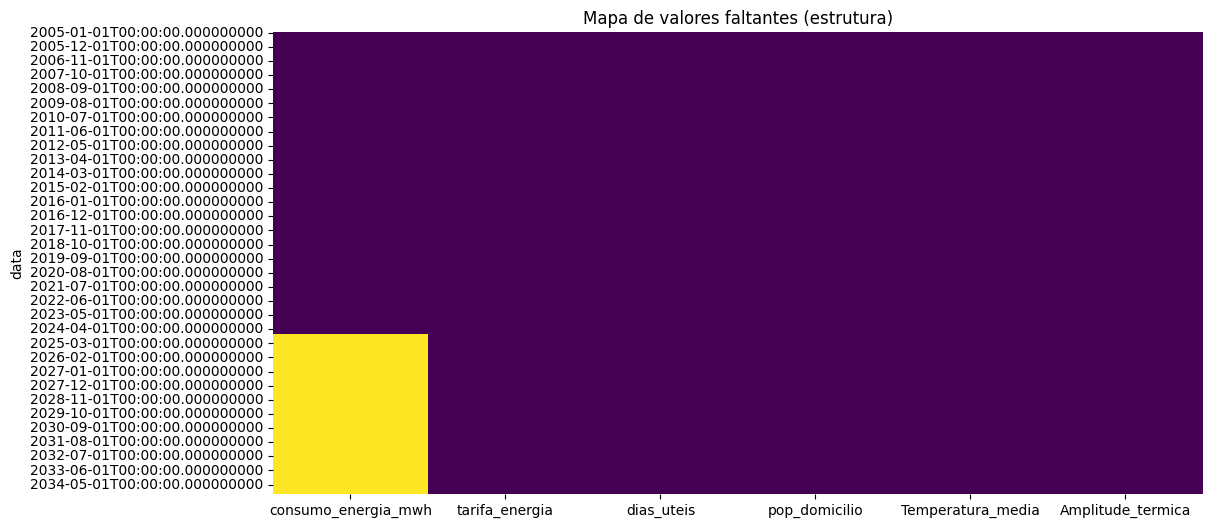

In [5]:
# Converter coluna de data para datetime
df['data'] = pd.to_datetime(df['data'])
df.set_index('data', inplace=True)

# visualizar horizonte temporal
print(f"\nPeríodo dos dados: {df.index.min()} até {df.index.max()}")
print(f"Total de registros: {len(df)}")

# Verificar dados faltantes
print(df.isnull().sum())

# plot missings
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Mapa de valores faltantes (estrutura)")
plt.show()

**Nota**

* Período dos dados: 2005-01-01 até 2034-12-01
* Total de registros: 360
* A coluna consumo_energia_mwh que vamos prever, ou seja, ela é nosso target. Temos dados de 2005-01-01 a 2024-07-01 e queremos prever de 2024-08-01 a 2034-12-01.
* Temos váriaveis explicativas para todo o período

### Definir dados históricos

In [6]:
# Definir dados históricos
dados_historicos = df.dropna(subset=['consumo_energia_mwh'])
dados_futuros = df[df['consumo_energia_mwh'].isna()]

print(f"\n ESTRUTURA DOS DADOS:")
print(f" Dados históricos (com consumo): {len(dados_historicos)} registros")
print(f"   • Período: {dados_historicos.index.min().strftime('%Y-%m')} até {dados_historicos.index.max().strftime('%Y-%m')}")
print(f" Dados futuros (para prever): {len(dados_futuros)} registros")
print(f"   • Período: {dados_futuros.index.min().strftime('%Y-%m')} até {dados_futuros.index.max().strftime('%Y-%m')}")



 ESTRUTURA DOS DADOS:
 Dados históricos (com consumo): 235 registros
   • Período: 2005-01 até 2024-07
 Dados futuros (para prever): 125 registros
   • Período: 2024-08 até 2034-12


### Plotar colunas do df

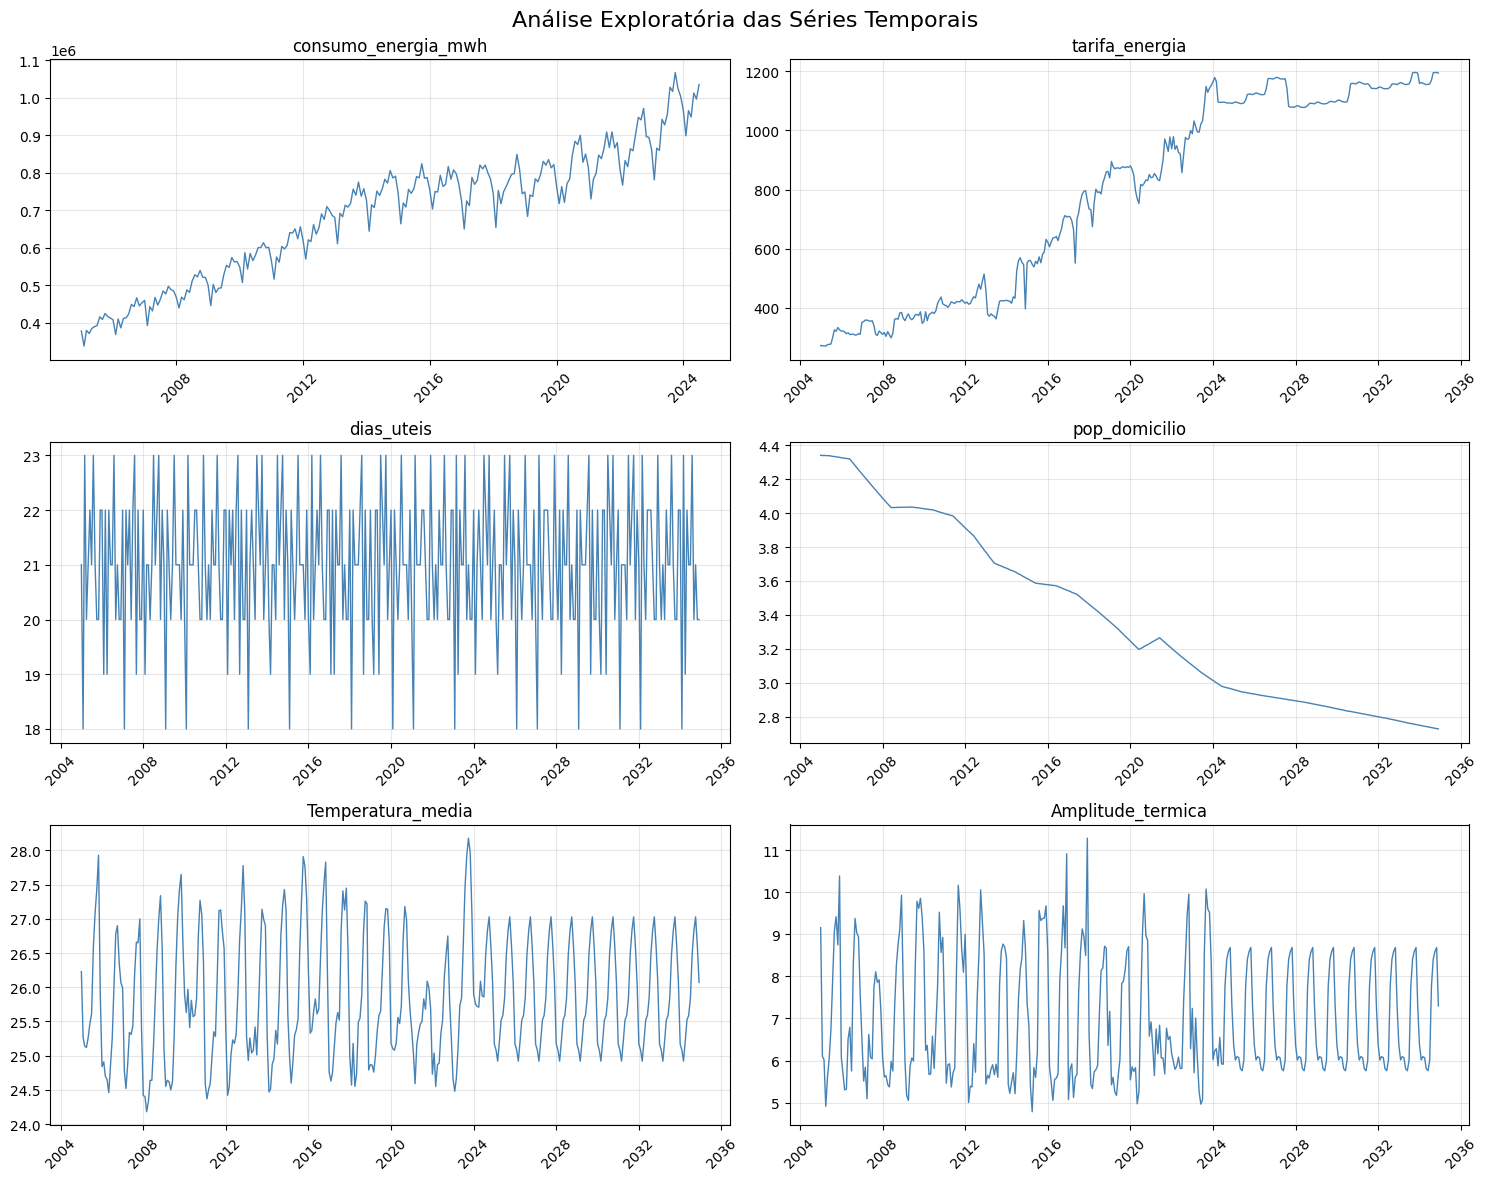

In [7]:
# Configurar matplotlib
plt.style.use('default')
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Análise Exploratória das Séries Temporais', fontsize=16)

variables = ['consumo_energia_mwh', 'tarifa_energia', 'dias_uteis',
             'pop_domicilio', 'Temperatura_media', 'Amplitude_termica']

for i, var in enumerate(variables):
    ax = axes[i//2, i%2]
    ax.plot(df.index, df[var], linewidth=1, color='steelblue')
    ax.set_title(f'{var}')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('exploracao_dados.png', dpi=300, bbox_inches='tight')
plt.show()


### Matriz de correlação

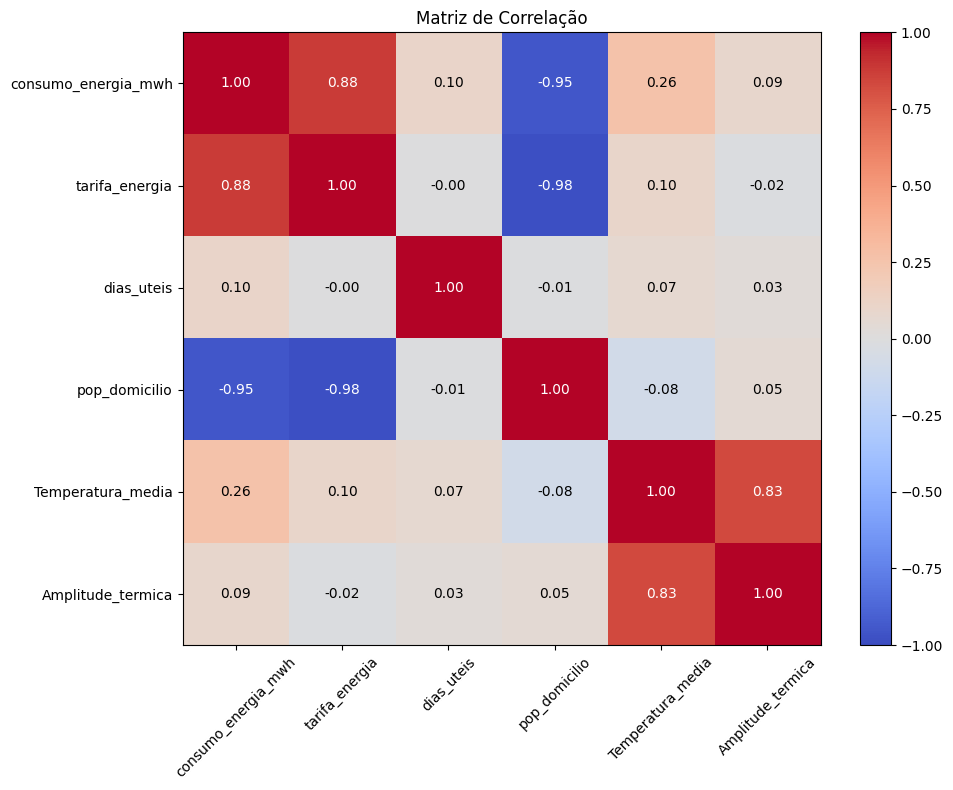

In [8]:
# Matriz de correlação
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
im = plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(im)
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Matriz de Correlação')

for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                ha='center', va='center', color='white' if abs(correlation_matrix.iloc[i, j]) > 0.5 else 'black')

plt.tight_layout()
plt.savefig('matriz_correlacao.png', dpi=300, bbox_inches='tight')
plt.show()

### Gerar funções para prepadar dados e modelo

In [25]:
#===============================================================
# Função para preparar dados e separar dataframes
#===============================================================
def preparar_dados_desde_df_unificado(df_unificado, target_col, test_size):

    print("Iniciando preparação de dados a partir de DataFrame unificado...")

    # Copiar para não alterar o DataFrame original fora da função
    df_mestre = df_unificado.copy()

    # --- ETAPA 1: GERAR FEATURES DE FORMA CONTÍNUA ---
    print("Gerando features de tempo e tendência...")
    df_mestre['tendencia'] = np.arange(len(df_mestre))
    df_mestre['mes_sin'] = np.sin(2 * np.pi * df_mestre.index.month / 12)
    df_mestre['mes_cos'] = np.cos(2 * np.pi * df_mestre.index.month / 12)
    df_mestre['trimestre_sin'] = np.sin(2 * np.pi * df_mestre.index.quarter / 4)
    df_mestre['trimestre_cos'] = np.cos(2 * np.pi * df_mestre.index.quarter / 4)
    df_mestre['periodo_seco'] = ((df_mestre.index.month >= 5) & (df_mestre.index.month <= 9)).astype(int)

    # --- ETAPA 2: DIVIDIR O DATAFRAME USANDO O ALVO ---
    print("Dividindo em Histórico (alvo preenchido) e Futuro (alvo NaN)...")
    df_historico = df_mestre[df_mestre[target_col].notna()].copy()
    df_futuro = df_mestre[df_mestre[target_col].isna()].copy()

    # Preparar features e alvo do período histórico
    X_historico = df_historico.drop(columns=[target_col])
    y_historico = df_historico[target_col]

    X_futuro = df_futuro.drop(columns=[target_col])

    # Dividir o histórico em treino e teste
    split_index = int(len(X_historico) * (1 - test_size))
    X_train = X_historico.iloc[:split_index]
    X_test = X_historico.iloc[split_index:]
    y_train = y_historico.iloc[:split_index]
    y_test = y_historico.iloc[split_index:]

    print(f"  - Histórico: {len(df_historico)} | Treino: {len(X_train)} | Teste: {len(X_test)}")
    print(f"  - Futuro: {len(X_futuro)}")

    # --- ETAPA 3: NORMALIZAÇÃO ---
    print("Normalizando os conjuntos de dados...")
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()

    X_test_scaled = scaler_X.transform(X_test)
    X_futuro_scaled = scaler_X.transform(X_futuro)

    joblib.dump(scaler_X, 'scaler_X.pkl')
    joblib.dump(scaler_y, 'scaler_y.pkl')
    print("  - Normalizadores salvos.")

    return (
        X_train_scaled, X_test_scaled, X_futuro_scaled,
        y_train_scaled,
        y_train, y_test,
        X_futuro,
        scaler_X, scaler_y
    )

#===============================================================
# Montar dataframes
#===============================================================

### Definir particionamento de test
TestSize = 0.02

### Gerar dataframes de treino e teste
(X_train_scaled,
 X_test_scaled,
 X_futuro_scaled,
 y_train_scaled,
 y_train,
 y_test,
 df_futuro_completo,
 scaler_X,
 scaler_y
 ) = preparar_dados_desde_df_unificado(
     df_unificado= df,
     target_col='consumo_energia_mwh',
     test_size=TestSize
     )

Iniciando preparação de dados a partir de DataFrame unificado...
Gerando features de tempo e tendência...
Dividindo em Histórico (alvo preenchido) e Futuro (alvo NaN)...
  - Histórico: 235 | Treino: 230 | Teste: 5
  - Futuro: 125
Normalizando os conjuntos de dados...
  - Normalizadores salvos.


### Execução do fluxo até o treinamento

In [35]:
#===============================================================
# Função treinamento
#===============================================================
def criar_modelo_autokeras(max_trials=100):
    input_node = ak.Input()
    output_node = ak.RegressionHead(metrics=['mape'])(input_node)
    automodel = ak.AutoModel(
        inputs=input_node,
        outputs=output_node,
        max_trials=max_trials,
        directory='autokeras_final_dir',
        project_name='energia_forecast_final',
        overwrite=True,
        objective="val_loss",
        tuner="greedy",
        seed=SEED
    )
    return automodel

### Criar o modelo AutoKeras
automodel = criar_modelo_autokeras(max_trials=100)

### Treinar o modelo AutoKeras
print("\nIniciando o treinamento do AutoKeras...")
automodel.fit(
    X_train_scaled,
    y_train_scaled,
    batch_size=32,
    validation_split=TestSize,
    epochs=100,
    verbose=1, # Mude para 1 para ver o progresso do treino
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    ]
)
print("Treinamento concluído!")

Trial 24 Complete [00h 00m 16s]
val_loss: 0.09731592983007431

Best val_loss So Far: 0.0007356124115176499
Total elapsed time: 00h 05m 15s
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4703 - mape: 6951233.5000   
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5052 - mape: 10171424.0000 
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2501 - mape: 6046742.5000  
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0991 - mape: 2475741.7500 
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0339 - mape: 933877.5000  
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0432 - mape: 81358.4219  
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0171 - mape: 643873.8125  
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0326 - mape: 1513531.6250 
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0283 - mape: 2087398.0000 
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0232 - mape: 1009685.375

### Avaliar modelo nos dados de teste

In [36]:
# avaliar nos dados de teste
y_pred_scaled = automodel.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
print(f"Predições de teste concluídas: {len(y_pred)} valores")

# Calcular as métricas de avaliação
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100 # Multiplicar por 100 para obter %

print("\nMétricas de Avaliação no Conjunto de Teste:")
print(f"MAE: {mae:,.2f} MWh")
print(f"RMSE: {rmse:,.2f} MWh")
print(f"MAPE: {mape:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predições de teste concluídas: 5 valores

Métricas de Avaliação no Conjunto de Teste:
MAE: 14,601.81 MWh
RMSE: 17,424.41 MWh
MAPE: 1.46%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Métricas de Avaliação no Conjunto de Teste:
MAE: 14,601.81 MWh
RMSE: 17,424.41 MWh
MAPE: 1.46%
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


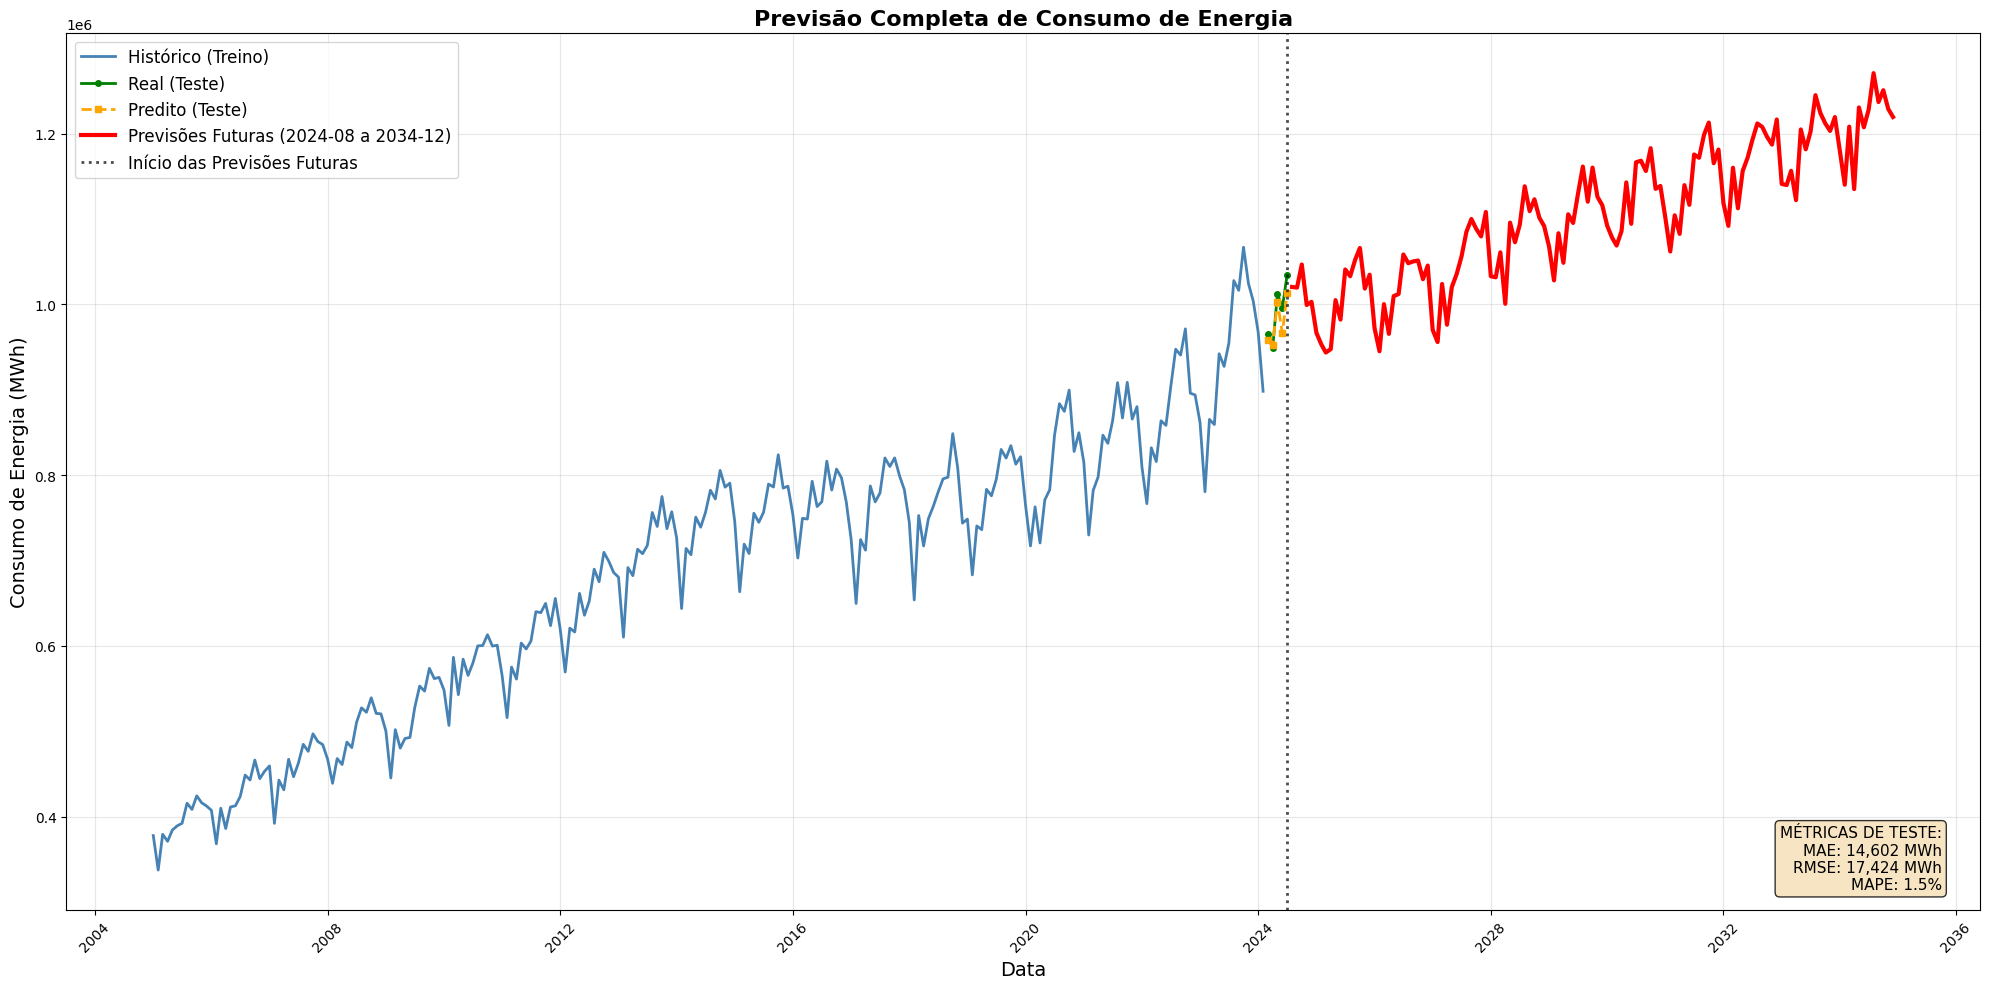


RESUMO DAS PREVISÕES FUTURAS:
Período: 2024-08 até 2034-12
Total de previsões: 125
Consumo médio previsto: 1,104,322 MWh

CONSUMO PREVISTO POR ANO:
           mean         sum
ano                        
2024  1017764.0   5088822.0
2025  1003574.0  12042893.0
2026  1015631.0  12187573.0
2027  1041583.0  12498991.0
2028  1079277.0  12951320.0
2029  1103404.0  13240842.0
2030  1125763.0  13509161.0
2031  1142620.0  13711442.0
2032  1168576.0  14022915.0
2033  1187573.0  14250879.0
2034  1211285.0  14535423.0


In [39]:
# --- PREDIÇÃO E AVALIAÇÃO ---

### Fazer predict nos dados de TESTE
y_pred_scaled = automodel.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# cálculo das métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print("\nMétricas de Avaliação no Conjunto de Teste:")
print(f"MAE: {mae:,.2f} MWh")
print(f"RMSE: {rmse:,.2f} MWh")
print(f"MAPE: {mape:.2f}%")

### Fazer predict nos dados futuros
y_futuro_scaled = automodel.predict(X_futuro_scaled)
y_futuro = scaler_y.inverse_transform(y_futuro_scaled.reshape(-1, 1)).flatten()


# --- PLOTAGEM DOS RESULTADOS ---

plt.figure(figsize=(20, 10))

# Dados históricos (treino)
plt.plot(y_train.index, y_train, label='Histórico (Treino)', color='steelblue', linewidth=2)

# Dados reais de teste
plt.plot(y_test.index, y_test, label='Real (Teste)', color='green', linewidth=2, marker='o', markersize=4)

# Previsões de teste
plt.plot(y_test.index, y_pred, label='Predito (Teste)', color='orange', linewidth=2, linestyle='--', marker='s', markersize=4)

# plot com Legenda dinâmica que se ajusta ao período da previsão.
data_inicio_str = df_futuro_completo.index.min().strftime('%Y-%m')
data_fim_str = df_futuro_completo.index.max().strftime('%Y-%m')
label_futuro = f'Previsões Futuras ({data_inicio_str} a {data_fim_str})'

# Previsões futuras
plt.plot(df_futuro_completo.index, y_futuro, label=label_futuro, color='red', linewidth=3)

# Linha divisória, usando o final do conjunto de teste.
plt.axvline(x=y_test.index[-1], color='black', linestyle=':', alpha=0.7, linewidth=2, label='Início das Previsões Futuras')

plt.title('Previsão Completa de Consumo de Energia', fontsize=16, fontweight='bold')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Consumo de Energia (MWh)', fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Adicionar métricas no gráfico
textstr = f"MÉTRICAS DE TESTE:\nMAE: {mae:,.0f} MWh\nRMSE: {rmse:,.0f} MWh\nMAPE: {mape:.1f}%"
plt.text(0.98, 0.02, textstr, transform=plt.gca().transAxes, fontsize=11,
         verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()


# --- DATAFRAME FINAL COM AS PREVISÕES ---

df_previsoes_completas = pd.DataFrame({
    'data': df_futuro_completo.index,
    'consumo_previsto_mwh': y_futuro,
    'ano': df_futuro_completo.index.year,
    'mes': df_futuro_completo.index.month
})

print(f"\nRESUMO DAS PREVISÕES FUTURAS:")
print(f"Período: {df_previsoes_completas['data'].min().strftime('%Y-%m')} até {df_previsoes_completas['data'].max().strftime('%Y-%m')}")
print(f"Total de previsões: {len(df_previsoes_completas)}")
print(f"Consumo médio previsto: {np.mean(y_futuro):,.0f} MWh")

# Agrupar e exibir previsões por ano
previsoes_por_ano = df_previsoes_completas.groupby('ano')['consumo_previsto_mwh'].agg(['mean', 'sum']).round(0)
print(f"\nCONSUMO PREVISTO POR ANO:")
print(previsoes_por_ano)

In [40]:
best_model = automodel.export_model()
best_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32 (CastToFloat32) │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ regression_head_1 (Dense)       │ (None, 1)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

## PROXIMOS PASSOS

1. Coletar os hiperparâmetros escolhidos pelo AutoKeras:

2. Reproduzir o modelo manualmente com Keras utilizando hiperparâmetros do Autokeras e melhorar modelo

3. Reproduzir o modelo manualmente com Tensor Flow utilizando hiperparâmetros do keras

4. Avaliar e comparar as diferentes abordagens